# Keras_mnist_LeNet-5
**此项目初步实现LeNet-5**
- 达到0.9899的准确率

In [1]:
%matplotlib inline
import os
import PIL
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import keras

from IPython import display
from functools import partial
from sklearn.preprocessing import normalize

from keras import backend
from keras.utils import np_utils, plot_model
from keras.callbacks import TensorBoard, ModelCheckpoint
from keras.callbacks import LearningRateScheduler, ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator

from keras.models import load_model
from keras.models import Sequential, Model
from keras.layers import Dense, Conv2D, MaxPool2D, Input, AveragePooling2D
from keras.layers import Activation, Dropout, Flatten, BatchNormalization

import warnings 
warnings.filterwarnings('ignore')
np.random.seed(42)

Using TensorFlow backend.


In [2]:
file_path = r"I:\Dataset\mnist\all_mnist_data.csv"
mnist_data = pd.read_csv(file_path)

idx = np.random.permutation(len(mnist_data))
train_data = mnist_data.iloc[idx[: 60000]]
test_data = mnist_data.iloc[idx[60000: ]]

X_train = np.array(train_data.drop('0', axis=1)).reshape(-1, 28, 28, 1).astype("float32")
X_test  = np.array(test_data.drop('0', axis=1)).reshape(-1, 28, 28, 1).astype("float32")

y_train = np.array(train_data['0'])
y_test  = np.array(test_data['0'])
y_train = np_utils.to_categorical(y_train)
y_test  = np_utils.to_categorical(y_test)

x_train = X_train[10000:]
t_train = y_train[10000:]
x_val   = X_train[:10000]
t_val   = y_train[:10000]

print("\nimgs   of trainset : ", x_train.shape)
print("labels of trainset : ", t_train.shape)
print("imgs   of   valset : ", x_val.shape)
print("labels of   valset : ", t_val.shape)
print("imgs   of  testset : ", X_test.shape)
print("labels of  testset : ", y_test.shape)


imgs   of trainset :  (50000, 28, 28, 1)
labels of trainset :  (50000, 10)
imgs   of   valset :  (10000, 28, 28, 1)
labels of   valset :  (10000, 10)
imgs   of  testset :  (10000, 28, 28, 1)
labels of  testset :  (10000, 10)


In [3]:
def myCNN():
    model = Sequential()

    model.add(Conv2D(filters=6, 
                     kernel_size=(5, 5),
                     input_shape=(28, 28, 1),
                     padding="same",
                     activation="relu",
                     name="conv2d_1"))
    model.add(MaxPool2D(pool_size=(2, 2), name="maxpool2d_1"))

    model.add(Conv2D(filters=16, 
                     kernel_size=(5, 5),
                     input_shape=(14, 14, 1),
                     padding="valid",
                     activation="relu",
                     name="conv2d_2"))
    model.add(MaxPool2D(pool_size=(2, 2), name="maxpool2d_2"))

    model.add(Flatten())

    model.add(Dense(units=120, activation="relu"))
    model.add(Dropout(0.5))

    model.add(Dense(units=84, activation="relu"))
    model.add(Dropout(0.5))

    model.add(Dense(units=10, activation="softmax", name="output"))
    return model
model = myCNN()
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 28, 28, 6)         156       
_________________________________________________________________
maxpool2d_1 (MaxPooling2D)   (None, 14, 14, 6)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 10, 10, 16)        2416      
_________________________________________________________________
maxpool2d_2 (MaxPooling2D)   (None, 5, 5, 16)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 400)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 120)               48120     
_________________________________________________________________
dropout_1 (Dropout)          (None, 120)               0         
__________

In [4]:
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.2
sess = tf.Session(config=config)
backend.set_session(sess)

In [6]:
"""训练模型并保存模型及训练历史
保存模型单独创建一个子文件夹modeldir, 保存训练历史则为单个文件hisfile"""

models_name = "Keras_mnist_LeNet-5_v1" # 模型名称的公共前缀
factor_list = [""] # 此次调参的变量列表

model_list = []      # 模型名称列表
for i in range(len(factor_list)):
    modelname = models_name + factor_list[i] + ".h5"
    model_list.append(modelname)

# 创建模型保存子目录modeldir
if not os.path.isdir("saved_models"): 
    os.mkdir("saved_models")
modeldir = r"saved_models"

# 创建训练历史保存目录
if not os.path.isdir("train_history"): 
    os.mkdir("train_history")
# 设置训练历史文件路径
hisfile = r"train_history\Keras_mnist_LeNet-5_v1.train_history" 
# 每个模型及其对应的训练历史作为键值对{modelname: train_history}
# train_history为字典，含四个key，代表train和val的loss和acc
model_train_history = dict() 


# 开始训练
epochs=100
batch_size = 32
steps_per_epoch=1250
for i in range(len(model_list)):
    model = myCNN()
    modelname = model_list[i]
    modelpath = os.path.join(modeldir, modelname)    
    
    train_his = np.array([]).reshape(-1, 2)
    val_his = np.array([]).reshape(-1, 2)
    
    datagen = ImageDataGenerator()
    datagen.fit(x_train)
    model.compile(loss="categorical_crossentropy", 
                  optimizer=keras.optimizers.Adam(),
                  metrics=["accuracy"])
    print("\ntraining model : ", modelname)
    
    ck_epoch, max_val_acc = 0, 0.0
    for epoch in range(epochs+1):
        i = 0
        tr_his = []
        for X, y in datagen.flow(x_train, t_train, batch_size=batch_size):
            his = model.train_on_batch(X, y)
            tr_his.append(his)
            i += 1
            if i >= steps_per_epoch: break
        tr = np.mean(tr_his, axis=0)
        val = model.evaluate(x_val, t_val, verbose=0)
        train_his = np.vstack((train_his, tr))
        val_his = np.vstack((val_his, val))
        if epoch<10 or epoch %5 == 0:
            print("%4d epoch: train acc: %8f loss: %8f      val acc: %8f loss: %8f"%(epoch, tr[1], tr[0], val[1], val[0]))
        # 设置保存模型
        if val[1] > max_val_acc: 
            model.save(modelpath)
            print("val acc improved from %6f to %6f"%(max_val_acc, val[1]))
            max_val_acc = val[1]
            ck_epoch = epoch
    model_train_history[modelname] = {"acc": train_his[:, 1], "val_acc": val_his[:, 1],
                                      "loss": train_his[:, 0], "val_loss": val_his[:, 0]}

"""保存训练历史"""
fo = open(hisfile, 'wb')
pickle.dump(model_train_history, fo)
fo.close()


training model :  Keras_mnist_LeNet-5_v1.h5
   0 epoch: train acc: 0.830825 loss: 0.521261      val acc: 0.968300 loss: 0.109448
val acc improved from 0.000000 to 0.968300
   1 epoch: train acc: 0.953375 loss: 0.170999      val acc: 0.976500 loss: 0.083982
val acc improved from 0.968300 to 0.976500
   2 epoch: train acc: 0.967925 loss: 0.121791      val acc: 0.981700 loss: 0.068372
val acc improved from 0.976500 to 0.981700
   3 epoch: train acc: 0.973675 loss: 0.101520      val acc: 0.982700 loss: 0.057778
val acc improved from 0.981700 to 0.982700
   4 epoch: train acc: 0.976625 loss: 0.087698      val acc: 0.984700 loss: 0.052580
val acc improved from 0.982700 to 0.984700
   5 epoch: train acc: 0.978850 loss: 0.081113      val acc: 0.984900 loss: 0.058881
val acc improved from 0.984700 to 0.984900
   6 epoch: train acc: 0.981900 loss: 0.066123      val acc: 0.984400 loss: 0.061769
   7 epoch: train acc: 0.982475 loss: 0.065164      val acc: 0.985800 loss: 0.052492
val acc improved 

## 可视化训练过程

In [7]:
def show_train_history(saved_history, his_img_file):  
    modelnames = sorted(list(saved_history.keys()))
    train = ["acc", "loss"]
    val = ["val_acc", "val_loss"]
    
    """作loss和acc两个图"""
    fig, ax = plt.subplots(1, 2, figsize=(16, 5))
    ax = ax.flatten()
    color_add = 0.9/len(saved_history)
    for i in range(2):
        c = 0.05
        for j in range(len(saved_history)):
            modelname = modelnames[j]
            train_history = saved_history[modelname]
            ax[i].plot(train_history[train[i]], 
                       color=(0, 1-c, 0),
                       linestyle="-",
                       label="train_"+modelname[21:-3])
            ax[i].plot(train_history[val[i]], 
                       color=(c, 0, 1-c),
                       linestyle="-",
                       label="val_"+modelname[21:-3])
            c += color_add
        ax[i].set_title('Train History')
        ax[i].set_ylabel(train[i])  
        ax[i].set_xlabel('Epoch')  
    ax[0].legend(loc="lower right")
    ax[1].legend(loc="upper right") 
    ax[0].set_ylim(0.9, 1.0)
    ax[1].set_ylim(0, 0.2)
    plt.suptitle("LeNet-5_v1")
    
    print("saved img: ", his_img_file)
    plt.savefig(his_img_file)
    plt.show()

saved img:  his_img\LeNet-5_v1.png


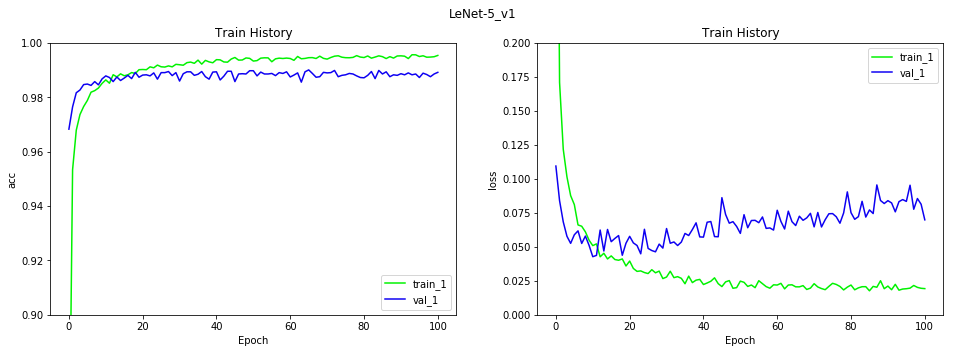

In [8]:
"""载入训练历史并可视化, 并且保存图片"""
if not os.path.isdir("his_img"):
    os.mkdir("his_img")
his_img_file = r"his_img\LeNet-5_v1.png"

fo2 = open(hisfile, "rb")
saved_history1 = pickle.load(fo2)

show_train_history(saved_history1, his_img_file)

## 在测试集上测试

In [12]:
smodel = load_model(modelpath)
print("test model : ", os.path.basename(modelpath))
loss, acc = smodel.evaluate(X_test, y_test)
print("test ：acc: %.4f"%(acc))

test model :  Keras_mnist_LeNet-5_v1.h5
10000/10000 [==============================] - 5s 497us/step
test ：acc: 0.9899
